In [ ]:
import torch
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Add project root to path
sys.path.append(os.path.abspath('..'))
from src.models.model import get_model
from src.utils.inference import predict_flower

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# Load the trained model
model = get_model(num_classes=102).to(device)

# Check if model weights exist
model_path = '../best_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("✓ Weights loaded successfully from best_model.pth")
else:
    print("⚠️ Warning: best_model.pth not found. Please train the model first using 02_Training.ipynb")
    print("   Continuing with untrained model for demonstration purposes...")

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import datasets, transforms

# Load a sample image from the validation set
val_dataset = datasets.Flowers102(root='../data', split='val', download=True)
sample_idx = 0  # Change this to visualize different images
sample_image, sample_label = val_dataset[sample_idx]

# Prepare image for model
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_tensor = transform(sample_image).unsqueeze(0).to(device)

# Get model prediction
with torch.no_grad():
    output = model(input_tensor)
    predicted_class = output.argmax(dim=1).item()

print(f"True class: {sample_label}")
print(f"Predicted class: {predicted_class}")

# Setup Grad-CAM
target_layers = [model.layer4[-1]]  # Last layer of ResNet block 4
cam = GradCAM(model=model, target_layers=target_layers)

# Generate CAM
targets = [ClassifierOutputTarget(predicted_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]

# Prepare original image for visualization
rgb_img = np.array(sample_image.resize((224, 224))) / 255.0
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_image)
axes[0].set_title(f'Original Image\nTrue Class: {sample_label}')
axes[0].axis('off')

axes[1].imshow(grayscale_cam, cmap='jet')
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

axes[2].imshow(visualization)
axes[2].set_title(f'Grad-CAM Overlay\nPredicted: {predicted_class}')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nGrad-CAM highlights the regions the model focuses on for classification.")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import DataLoader
import seaborn as sns
from tqdm.notebook import tqdm

# Load validation dataset
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_dataset = datasets.Flowers102(root='../data', split='val', download=True, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Generate predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Confusion Matrix (showing subset for readability)
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix (first 20 classes for visibility)
plt.figure(figsize=(12, 10))
sns.heatmap(cm[:20, :20], annot=False, fmt='d', cmap='Blues', 
            xticklabels=range(20), yticklabels=range(20))
plt.title('Confusion Matrix (First 20 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Classification report for first 10 classes
print("\nClassification Report (Sample - First 10 Classes):")
print(classification_report(all_labels, all_preds, labels=list(range(10)), zero_division=0))

In [ ]:
# Test inference function with a sample image
# Get a random image from validation set
from torchvision import datasets

val_dataset_raw = datasets.Flowers102(root='../data', split='val', download=True)
test_image, true_label = val_dataset_raw[5]  # Get 6th image

# Save temporarily for testing
test_image_path = '../temp_test_image.jpg'
test_image.save(test_image_path)

# Run inference
result = predict_flower(test_image_path, model, device, top_k=3)

print("Final Production Output:")
print(f"Predicted Class: {result['predicted_class']}")
print(f"Confidence Score: {result['confidence_score']:.4f}")
print(f"\nTop 3 Predictions:")
for i, pred in enumerate(result['top_3'], 1):
    print(f"  {i}. Class {pred['class']}: {pred['confidence']:.4f}")

print(f"\nTrue Label: {true_label}")
print(f"Correct: {result['predicted_class'] == true_label}")

# Display the test image
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title(f"Test Image\nTrue: {true_label} | Predicted: {result['predicted_class']}")
plt.axis('off')
plt.show()

# Clean up
if os.path.exists(test_image_path):
    os.remove(test_image_path)

Comment:
1. Standardardized Input:
- Resize image to 256 x 256 then 224 x 224, ensuring consistent input tensor for the pre-trained model
2. Limited data :
- Random image transformation to create variety in data.
3. Normalizing data:
- Ensuring flower image are compatible with pre-trained weights of the model
4. Improved hardware utilization:
- different batch sizes to reduce training time, avoid learning in order of classes and uses parallel image processing

2.1
Model selection:
- RestNet50: Solves vanishing gradient problem
- More effecient on T4 GPU
- EfficientNet: slower training
- ViT: Too little data to train on

Fine tuning strategy:
- Backbone freezing : used to leverage pre-trained ImageNet weights
- Learn Rate scheduling: to ensure once model reached performance limit, learning rate decreases to allow for finer weight adjustments.


Training Infrastructure:
- Early stopping: Used validation_loss to stop training if loss did not improve over rounds
- Model checkpointing: implemented best_model.pth to save best model weights when validation loss reached a new minimum.
- Random seetds set at 42 at the start of script
- Class imbalance ignored since all class are exactly the same.



Part 3 Evaluation and analysis.

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.80      0.63        20
           1       0.88      0.88      0.88        40
           2       0.41      0.35      0.38        20
           3       0.53      0.44      0.48        36
           4       0.95      0.78      0.85        45
           5       0.86      0.96      0.91        25
           6       0.66      0.95      0.78        20
           7       0.96      1.00      0.98        65
           8       0.54      0.96      0.69        26
           9       0.96      0.92      0.94        25
          10       0.88      0.64      0.74        67
          11       0.95      0.91      0.93        67
          12       0.75      0.93      0.83        29
          13       0.82      0.96      0.89        28
          14       0.75      0.93      0.83        29
          15       0.74      0.67      0.70        21
          16       0.98      0.97      0.98        65
          17       0.63      0.74      0.68        62
          18       0.63      0.76      0.69        29
          19       0.80      0.78      0.79        36
          20       0.63      0.95      0.76        20
          21       0.95      0.90      0.92        39
          22       1.00      0.86      0.92        71
          23       0.73      0.86      0.79        22
          24       0.95      0.90      0.93        21
          25       0.83      0.71      0.77        21
          26       0.95      1.00      0.98        20
          27       0.95      0.85      0.90        46
          28       0.92      0.95      0.93        58
          29       0.81      0.71      0.75        65
          30       0.96      0.69      0.80        32
          31       0.50      0.72      0.59        25
          32       0.89      0.96      0.93        26
          33       0.82      0.70      0.76        20
          34       0.95      0.83      0.88        23
          35       0.85      0.82      0.83        55
          36       0.93      1.00      0.96        88
          37       0.77      1.00      0.87        36
          38       0.50      0.76      0.60        21
          39       0.72      0.66      0.69        47
          40       0.88      0.85      0.87       107
          41       0.94      0.87      0.91        39
          42       0.83      0.58      0.68       110
          43       0.80      0.96      0.88        73
          44       0.69      0.90      0.78        20
          45       0.87      0.97      0.92       176
          46       1.00      1.00      1.00        47
          47       0.91      0.94      0.92        51
          48       0.78      1.00      0.88        29
          49       0.97      0.93      0.95        72
          50       0.95      0.45      0.61       238
          51       0.88      0.92      0.90        65
          52       0.82      0.68      0.75        73
          53       0.95      0.93      0.94        41
          54       0.74      0.96      0.84        51
          55       0.89      0.99      0.94        89
          56       0.73      0.85      0.78        47
          57       0.94      0.98      0.96        94
          58       0.92      1.00      0.96        47
          59       0.92      1.00      0.96        89
          60       0.97      0.97      0.97        30
          61       0.84      0.74      0.79        35
          62       0.94      1.00      0.97        34
          63       0.91      1.00      0.96        32
          64       0.94      0.94      0.94        82
          65       0.80      1.00      0.89        41
          66       0.43      0.73      0.54        22
          67       0.82      0.79      0.81        34
          68       0.87      1.00      0.93        34
          69       0.97      0.86      0.91        42
          70       0.82      0.97      0.89        58
          71       0.75      0.68      0.72        76
          72       0.89      0.94      0.91       174
          73       0.96      0.44      0.60       151
          74       0.87      0.93      0.90       100
          75       0.81      0.75      0.78        87
          76       0.93      1.00      0.96       231
          77       0.73      0.84      0.78       117
          78       1.00      0.95      0.98        21
          79       0.84      0.98      0.90        85
          80       0.99      0.97      0.98       146
          81       0.85      0.57      0.68        92
          82       0.87      0.59      0.70       111
          83       0.75      0.68      0.71        66
          84       0.74      0.79      0.76        43
          85       0.35      1.00      0.51        38
          86       0.65      0.91      0.76        43
          87       0.83      0.61      0.70       134
          88       0.87      0.86      0.87       164
          89       0.75      0.74      0.75        62
          90       0.89      0.88      0.88        56
          91       0.91      0.89      0.90        46
          92       0.75      0.92      0.83        26
          93       0.89      0.98      0.93       142
          94       0.94      0.85      0.89       108
          95       0.59      0.68      0.63        71
          96       0.61      0.78      0.69        46
          97       0.97      0.45      0.62        62
          98       0.70      0.93      0.80        43
          99       0.84      0.93      0.89        29
         100       0.52      0.87      0.65        38
         101       0.71      0.96      0.82        28

    accuracy                           0.83      6149
   macro avg       0.82      0.85      0.82      6149
weighted avg       0.85      0.83      0.83      6149

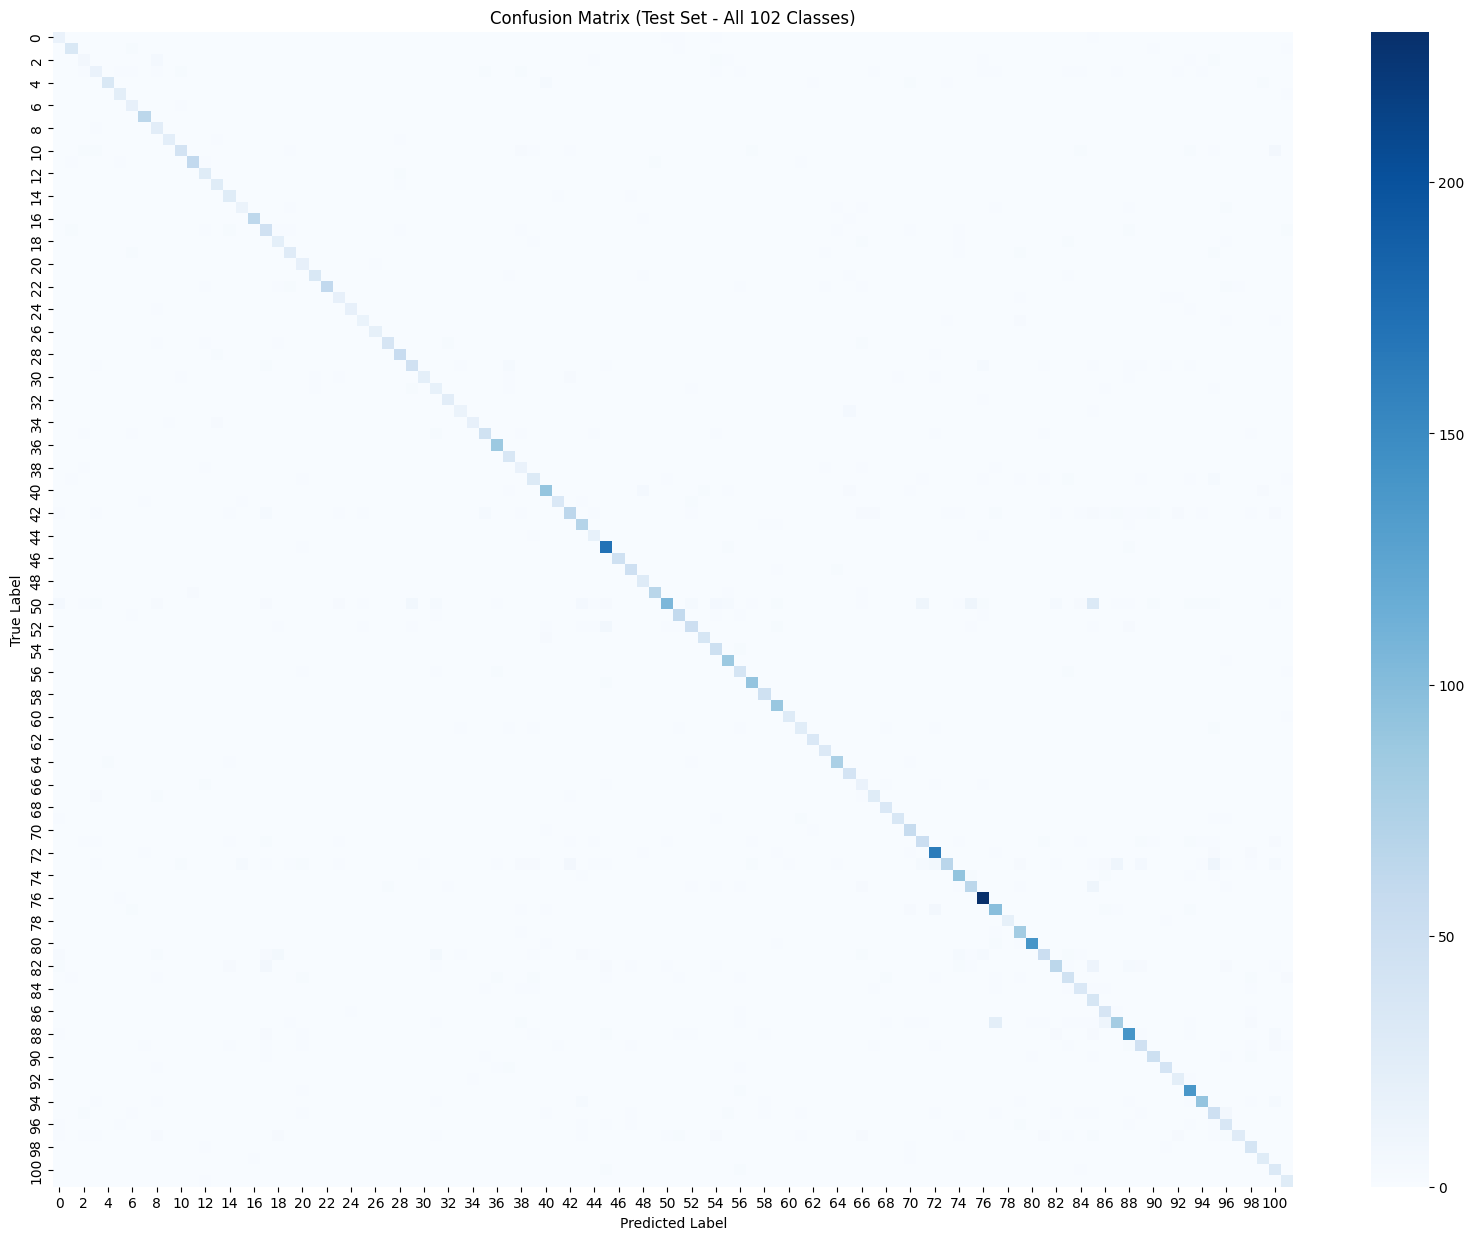


Analysis of confusion matrix:
- Minimal noise, most results fall under remain within diagonal line
- Classes with highest success are 46,76, 80.
- X axis shows the predicted label (using ResNet-50)
- Y axis shows ground truth from the dataset
- Overall results were very accurate.


ROC Curve Analysis:
- High true positive rate even at low false positive threshold
- SHows that the results is good at ranking right answers near top.
- 0.99 proves that ResNet50 actually did learn the difference between species, the model is reliable at ranking correct species highly.

Error Analysis:
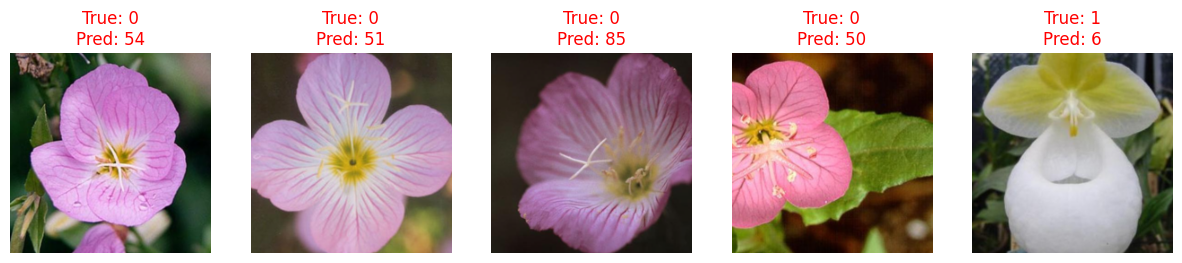


- Most common misclassificationsdue to semantic overlap. All pink flowers, but missing further details to distinguish them (such as stamen shape or leaf texture)
- Cropped images affects the full symmetry of petals, affected perfomance.
- Suggestions:
  - Increase image resolution to see finer details such as stamen and petal veins.
  - Take multiple crops and flips of same image and average the prediction to improve the performance
  - Implement label smoothing to improve training data
  - Use vision transformer to help focus on the center of flower

Part 3.3 Model Analysis

Performance vs dataset complexity
- With a test accuracy of 83.07% and ROC of 0.99, this is a strong result given the limited training data. The Oxford 102 flower dataset shows that the interclass variance is extremely low and the interclass variance is high (many species looking near identical and some of the same species can look different due to lighting)

Trade-off analysis
- ResNet-50 was chosen due to its optimal balance for research application.
- ResNet-50 is also significantly faster compared to vision transformers, making it more suitable for real-time identification.
- Model size is sufficient to fit into memory-constrained environments, and while it provides sufficient accuracy.
- ResNet-50 does provide enough accuracy. While a larger model might increase the performance and accuracy, the cost in terms of increased latency and power consumption would not be a good trade-off. (since test accuracy at 83.07% and ROC at 0.99)

Hyperparameter Tuning Experiments
- The first strategy was to implement backbone freezing. This is so that ImageNet would learn the features early on in the training phase.
- The second strategy implemented was the learning rate scheduling. This allowed the model to use higher learning rates for rapid initial convergence and automatically drop the rate when validation loss flattens.
- The third strategy implemented was early stopping. By setting patients of five epochs on validation loss, this prevented the model from overfitting on the small training set.

Correct: 0
Visualization:
- The model ignores the surrounding green leaves and background clutter. It's concluded that it's making the right decision.
- The result suggests that the model has successfully learned about the flower and its internal petal patterns.


True: 0, Pred:54
Visualization:
- The model did not successfully identify the center of the flower and identified a green leaf in the background instead.


Comments:
- The model demonstrates strong botanical feature extraction. This indicate that ResNet-50 backbone is suitable for fine-grained internal flower structures over global shapes.
- For the misclassified samples, this also highlights the downside of this model, which suggests that it occasionally relies on spatial context rather than the primary object.
- Further training with random erasing or mixup augmentation could help the model to look at more diverse parts of the flower rather than just the edges.